# Sentiment Analysis of Extreme Growth AI Firms
This notebook adapts the Baker and Wurgler (2006) framework to analyze how investor sentiment impacts the valuation and returns of "extreme growth" AI firms, using proxies like closed-end fund discounts, share turnover ratios, and additional indicators such as the NASDAQ-100 Volatility Index (VXN) and momentum factors. The original paper can be found here :https://pages.stern.nyu.edu/~jwurgler/papers/wurgler_baker_cross_section.pdf. It focuses on four representative AI firms—Palantir, C3.ai, UiPath, and BigBear.ai—and segments the analysis into pre- and post-ChatGPT periods to examine shifts in market sentiment and dynamics. Additional theoretical details can be found in the accompanying paper.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import dataframe_image as dfi
from io import BytesIO
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import yfinance as yf
from datetime import datetime

# Calculate Portfolio Log Returns
This code reads stock data for Palantir, UiPath, BigBear.ai, and C3.ai, extracts relevant columns, 
computes daily weekly log returns for each stock, and calculates a weighted portfolio log return. 
The portfolio is constructed with predefined weights: 40% Palantir, 40% C3.ai, 10% UiPath, and 10% BigBear.ai.


In [2]:
cols = ['Date', 'Close', 'Volume', 'Share Turnover', 'Weighted ST']
pltr = pd.read_csv("PALANTIR_MAIN.csv", usecols=cols)
uipath = pd.read_csv("UIPATH_MAIN.csv", usecols=cols)
bbai = pd.read_csv("BBAI_MAIN.csv", usecols=cols)
c3ai = pd.read_csv("C3AI_MAIN.csv", usecols=cols)

pltr['Log Return'] = np.log(pltr['Close'] / pltr['Close'].shift(1))
c3ai['Log Return'] = np.log(c3ai['Close'] / c3ai['Close'].shift(1))
bbai['Log Return'] = np.log(bbai['Close'] / bbai['Close'].shift(1))
uipath['Log Return'] = np.log(uipath['Close'] / uipath['Close'].shift(1))

portfolio_log_return = (
    0.4 * pltr['Log Return'] +
    0.4 * c3ai['Log Return'] +
    0.1 * uipath['Log Return'] +
    0.1 * bbai['Log Return']
)

portfolio = pd.DataFrame()
portfolio['Date'] = pltr['Date']  # Align on the same dates
portfolio['Portfolio Log Return'] = portfolio_log_return
portfolio['Date'] = pd.to_datetime(portfolio['Date'])

C:\Users\tural\AppData\Local\Temp\ipykernel_20420\362959683.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  portfolio['Date'] = pd.to_datetime(portfolio['Date'])


In [3]:
scaler = StandardScaler()
portfolio['Portfolio Log Return'] = scaler.fit_transform(portfolio[['Portfolio Log Return']])

# Portfolio Log Returns and Rolling Volatility with Key Events
Here I retrieve daily stock prices for selected tickers (which are the same as our main weekle portfolio), calculate their log returns, and construct a weighted portfolio log return. It normalizes the portfolio log returns and computes 30-day rolling volatility. Key event, such as the start of the AI hype, is marked on the volatility plot, and volatility in the ±30-day window around each event is calculated and displayed.

[*********************100%***********************]  4 of 4 completed


Volatility around Start of AI hype (2022-12-22 to 2023-01-11): 0.033271


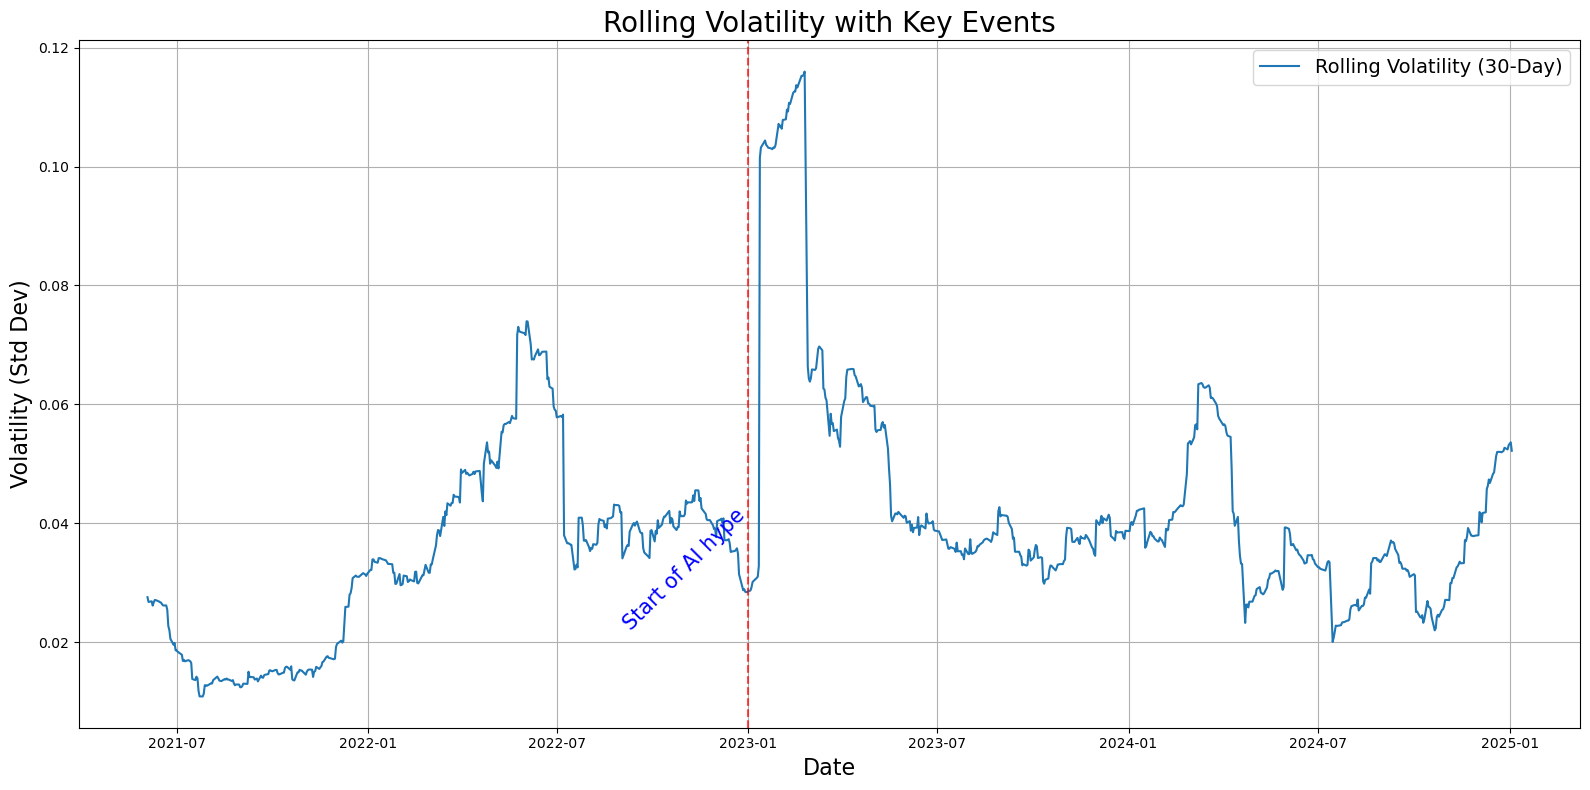

In [4]:
tickers = ['PATH', 'PLTR', 'AI', 'BBAI']  # List of ticker symbols
start_date = '2021-04-21'
end_date = datetime.today().strftime('%Y-%m-%d')
stocks = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Close']
stocks.columns = [f'Stock {i+1}' for i in range(len(stocks.columns))]
stocks.reset_index(inplace=True)
stocks['Date'] = pd.to_datetime(stocks['Date'])
dates = stocks['Date']
stocks = stocks[['Stock 1', 'Stock 2', 'Stock 3', 'Stock 4']]
log_returns = np.log(stocks / stocks.shift(1))
portfolio_log_return = (
    0.1 * log_returns['Stock 1'] +
    0.4 * log_returns['Stock 2'] +
    0.4 * log_returns['Stock 3'] +
    0.1 * log_returns['Stock 4']
)


stocks_portfolio = pd.DataFrame({
        'Portfolio Log Return': portfolio_log_return,
        'Date': dates
})

scaler = StandardScaler()

stocks_portfolio['Normalized Portfolio Log Return'] = scaler.fit_transform(stocks_portfolio[['Portfolio Log Return']])

events = [
    ("2023-01-01", "Start of AI hype")
]

stocks_portfolio['Rolling Volatility'] = stocks_portfolio['Portfolio Log Return'].rolling(window=30).std()
plt.figure(figsize=(16, 8))
plt.plot(stocks_portfolio['Date'], stocks_portfolio['Rolling Volatility'], label='Rolling Volatility (30-Day)')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Volatility (Std Dev)', fontsize=16)
plt.title('Rolling Volatility with Key Events', fontsize=20)
plt.grid(True)

vol_min = stocks_portfolio['Rolling Volatility'].min()
vol_max = stocks_portfolio['Rolling Volatility'].max()
label_y = vol_min + 0.1 * (vol_max - vol_min)

for date, label in events:
    event_date = pd.to_datetime(date).tz_localize('UTC') 
    window_start = event_date - pd.Timedelta(days=10)
    window_end = event_date + pd.Timedelta(days=10)
    plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.7)
    plt.text(event_date, label_y, label,
             rotation=45, fontsize=15, color='blue',
             ha='right', va='bottom') 
    window_volatility = stocks_portfolio[
        (stocks_portfolio['Date'] >= window_start) & (stocks_portfolio['Date'] <= window_end)
    ]['Portfolio Log Return'].std()
    print(f"Volatility around {label} ({window_start.date()} to {window_end.date()}): {window_volatility:.6f}")

plt.ylim(vol_min - 0.05 * (vol_max - vol_min), vol_max + 0.05 * (vol_max - vol_min))
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Calculate Portfolio Momentum
This code constructs a combined stock DataFrame by calculating the weighted average 'Close' prices of Palantir, C3.ai, UiPath, and BigBear.ai. It then computes a 4-week momentum metric based on the logarithmic rate of change relative to the stock price 4 weeks prior, and drops any resulting NaN values.

In [5]:

stocks = pd.DataFrame()
stocks['Close'] = (
    0.4 * pltr['Close'] +
    0.4 * c3ai['Close'] +
    0.1 * uipath['Close'] +
    0.1 * bbai['Close']
)

stocks['Momentum_4W'] = np.log(stocks['Close']/stocks['Close'].shift(4)) / np.log(stocks['Close'].shift(4))

stocks = stocks.dropna()

# Feature Selection and Normalization
This code calculates daily changes for VIX and share turnover, then normalizes portfolio log returns, share turnover changes, VIX changes, and 4-week momentum using standard scaling.

In [6]:
ST_main = pd.read_csv('ST_MAIN.csv')
VXN = pd.read_csv('VXN_data.csv')
VXN['d_VXN'] = np.log(VXN['Close'] / VXN['Close'].shift(1))
ST_main['d_ST'] = np.log(ST_main['Share Turnover'] / ST_main['Share Turnover'].shift(1))

ST_main['delta_ST'] = scaler.fit_transform(ST_main[['d_ST']])
VXN['delta_VXN'] = scaler.fit_transform(VXN[['d_VXN']])
stocks['Momentum_4W'] = scaler.fit_transform(stocks[['Momentum_4W']])

# CEFD Preprocessing and visualization
This code preprocesses CEFD data by converting discount values to percentages, normalizing them using MinMaxScaler, handling zero values by interpolation, and calculating daily log changes in normalized discounts.


In [7]:
CEFD = pd.read_csv('CEFD_MAIN')
CEFD['Discounts'] = CEFD['Discount'] * 100 * -1
scaler = MinMaxScaler()
CEFD['Normalized Discount'] = scaler.fit_transform(CEFD[['Discounts']])

num = []
for i in range(len(CEFD['Normalized Discount'])):
    if CEFD['Normalized Discount'][i] == 0:
        num.append(i)
if num != []:
    CEFD['Normalized Discount'][num[0]] = (CEFD['Normalized Discount'][num[0]-1] + 
                                       CEFD['Normalized Discount'][num[0]+1]) / 2

CEFD['d_CEFD'] = np.log(CEFD['Normalized Discount'] / CEFD['Normalized Discount'].shift(1))

C:\Users\tural\AppData\Local\Temp\ipykernel_20420\2779585012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CEFD['Normalized Discount'][num[0]] = (CEFD['Normalized Discount'][num[0]-1] +


In [8]:
scaler = StandardScaler()
CEFD['d_CEFD'] = scaler.fit_transform(CEFD[['d_CEFD']])

CEFs usually tend to trade below their NAV value. This code visualizes discounts for our chosen and weighted closed-end funds over time, comparing their discounts to NAV.

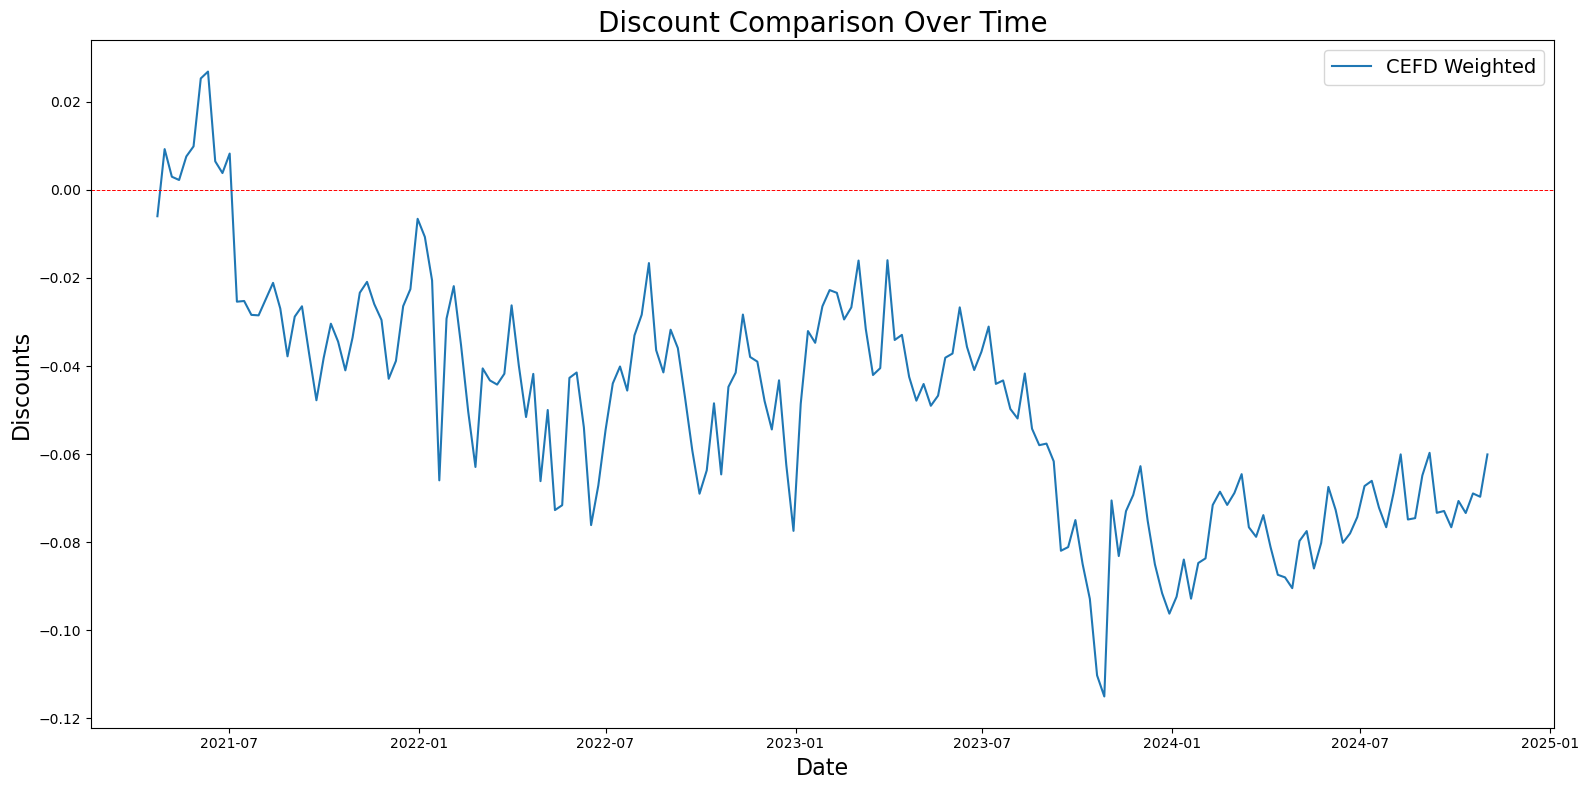

In [9]:
CEFD['Date'] = pd.to_datetime(CEFD['Date'])
plt.figure(figsize=(16, 8))
plt.plot(CEFD['Date'], CEFD['Discount'], label='CEFD Weighted')
plt.axhline(linewidth=0.7, color='r', linestyle = "--")
plt.xlabel('Date', fontsize=16)
plt.ylabel('Discounts', fontsize=16)
plt.title('Discount Comparison Over Time', fontsize=20)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Data formation

data = pd.DataFrame({
    'Portfolio Log Return': portfolio['Portfolio Log Return'],
    'd_ST Lag 2': ST_main['delta_ST'].shift(2),
    'd_ST Lag 1': ST_main['delta_ST'].shift(1),
    'd_ST': ST_main['delta_ST'],
    'd_VXN': VXN['delta_VXN'],
    'Momentum 4W': stocks['Momentum_4W'],
    'd_CEFD Lag 1': CEFD['d_CEFD'].shift(1),
    'd_CEFD Lag 2': CEFD['d_CEFD'].shift(2),
    'd_CEFD': CEFD['d_CEFD']
})

In [11]:
data = data.dropna()

In [12]:
data.head()

,Portfolio Log Return,d_ST Lag 2,d_ST Lag 1,d_ST,d_VXN,Momentum 4W,d_CEFD Lag 1,d_CEFD Lag 2,d_CEFD
4,1.147260,0.923899,0.854190,-1.605248,-0.291029,-0.367342,0.085884,1.022459,-0.852306
5,0.599256,0.854190,-1.605248,0.341820,-1.289575,-0.099678,-0.852306,0.085884,-0.450003
6,0.429735,-1.605248,0.341820,0.916620,-0.109382,0.589927,-0.450003,-0.852306,-8.161845
7,-0.210707,0.341820,0.916620,0.655403,-1.052325,0.595113,-8.161845,-0.450003,6.634204
8,0.031858,0.916620,0.655403,-0.931871,1.615029,0.019636,6.634204,-8.161845,2.095237


How to choose the best features?
# Feature Importance Analysis
This function computes feature importances using a Random Forest Regressor for a given timespan ('all', 'postgpt', or 'pregpt'). It splits the data into training and testing sets, trains the model, calculates importances, and plots them with error bars. Returns the sorted feature importances.


In [13]:
def feature_importance(timespan, dataframe, cols):
    if timespan == "all":
        df = dataframe
        plotname = "Feature importances using Random Forest Regressor"
    elif timespan == "postgpt":
        df = dataframe[89:]
        plotname = "Feature importances using Random Forest Regressor (After AI Hype)"
    elif timespan == "pregpt":
        df = dataframe[:89]
        plotname = "Feature importances using Random Forest Regressor (Before AI Hype)"
    else:
        raise ValueError("Invalid timespan value. Must be 'all', 'postgpt', or 'pregpt'.")

    X = df[cols]
    y = df.drop(columns=cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    forest = RandomForestRegressor(max_depth=2, random_state=0)
    forest.fit(X_train, y_train)

    importances = forest.feature_importances_
    forest_importances = pd.Series(importances, index=X.columns)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(plotname)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

    return forest_importances.sort_values(ascending=False)

In [14]:
columns = ['d_ST Lag 2', 'd_ST Lag 1', 'd_ST', 'Momentum 4W', 'd_VXN',
       'd_CEFD Lag 1', 'd_CEFD Lag 2', 'd_CEFD']
era = "postgpt"

C:\Users\tural\anaconda3\envs\Hands_on_ML\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Momentum 4W     0.407159
d_ST            0.279229
d_VXN           0.155350
d_CEFD          0.088988
d_ST Lag 1      0.027963
d_CEFD Lag 2    0.020189
d_ST Lag 2      0.016564
d_CEFD Lag 1    0.004559
dtype: float64

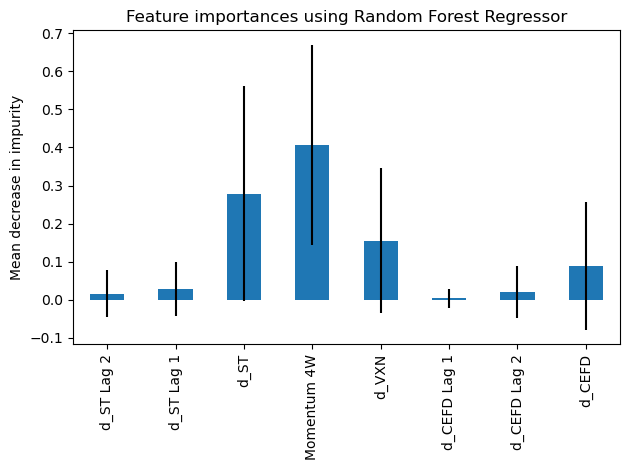

In [15]:
feature_importance(timespan = "all", dataframe = data, cols=columns)

C:\Users\tural\anaconda3\envs\Hands_on_ML\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Momentum 4W     0.393312
d_VXN           0.323447
d_ST            0.203885
d_ST Lag 1      0.024509
d_CEFD Lag 1    0.016188
d_ST Lag 2      0.015003
d_CEFD          0.013479
d_CEFD Lag 2    0.010178
dtype: float64

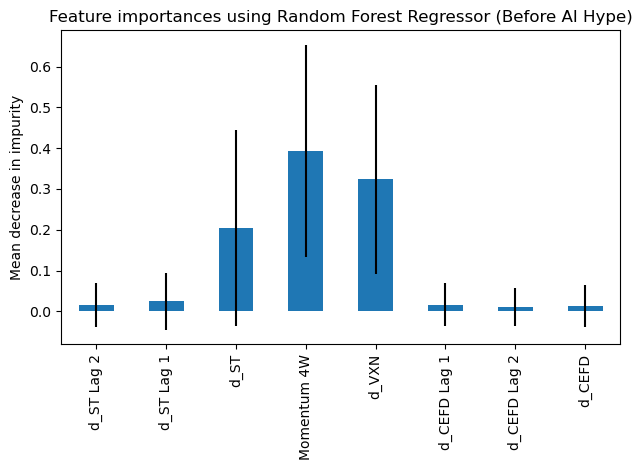

In [16]:
feature_importance(timespan = "pregpt", dataframe = data, cols=columns)

C:\Users\tural\anaconda3\envs\Hands_on_ML\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


d_ST            0.278537
Momentum 4W     0.193393
d_CEFD          0.162220
d_VXN           0.140315
d_CEFD Lag 1    0.094786
d_ST Lag 1      0.051441
d_CEFD Lag 2    0.048125
d_ST Lag 2      0.031182
dtype: float64

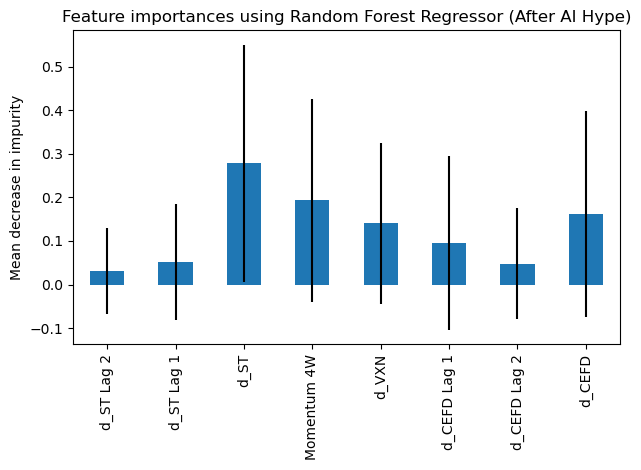

In [17]:
feature_importance(timespan = "postgpt", dataframe = data, cols=columns)

# Correlation Analysis

<Axes: >

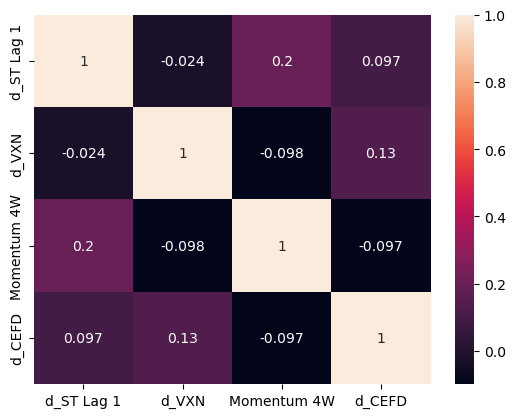

In [18]:
corr = data[['d_ST Lag 1', 'd_VXN', 'Momentum 4W', 'd_CEFD']].corr()
sns.heatmap(corr, annot=True)

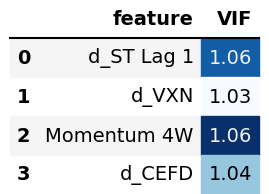

In [19]:
X = data[['d_ST Lag 1', 'd_VXN', 'Momentum 4W', 'd_CEFD']].dropna()
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

vif_data_styled = (vif_data
                   .style
                   .background_gradient(cmap='Blues', subset=['VIF'])
                   .format({'VIF': '{:.2f}'}))
vif_data_styled

buf = BytesIO()
dfi.export(
    vif_data_styled,
    buf,
    table_conversion='matplotlib',
    dpi=100      
)
buf.seek(0)

Image(buf.read())

# Stationarity Analysis

In [20]:
some_data = data[['d_ST Lag 1',
                  'd_VXN',
                  'd_CEFD',
                  'Momentum 4W',
                  'Portfolio Log Return'
                 ]]

In [21]:
for col in some_data.columns:
    series = some_data[col].dropna()
    
    result = adfuller(series)
    
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f"\n--- ADF Test for {col} ---")
    print(f"ADF Statistic: {adf_stat}")
    print(f"P-Value: {p_value}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    if p_value < 0.05:
        print(f"{col} is likely stationary (rejecting the null hypothesis of a unit root).")
    else:
        print(f"{col} is likely non-stationary (cannot reject the null hypothesis).")


--- ADF Test for d_ST Lag 1 ---
ADF Statistic: -5.793340060771741
P-Value: 4.815122545369014e-07
Critical Values:
   1%: -3.469413468959902
   5%: -2.8786964197028295
   10%: -2.5759166089965397
d_ST Lag 1 is likely stationary (rejecting the null hypothesis of a unit root).

--- ADF Test for d_VXN ---
ADF Statistic: -8.531154784912163
P-Value: 1.0368300993848003e-13
Critical Values:
   1%: -3.467845319799907
   5%: -2.878011745497439
   10%: -2.575551186759871
d_VXN is likely stationary (rejecting the null hypothesis of a unit root).

--- ADF Test for d_CEFD ---
ADF Statistic: -16.419569459033237
P-Value: 2.538013771293463e-29
Critical Values:
   1%: -3.467631519151906
   5%: -2.8779183721695567
   10%: -2.575501353364474
d_CEFD is likely stationary (rejecting the null hypothesis of a unit root).

--- ADF Test for Momentum 4W ---
ADF Statistic: -2.3361130091928697
P-Value: 0.16058512624994115
Critical Values:
   1%: -3.470126426071447
   5%: -2.8790075987120027
   10%: -2.576082696762

# Perform Regressions with Newey-West Standard Errors

In [23]:
X = data[['d_ST',
          'd_VXN',
          'd_CEFD Lag 1',
          'Momentum 4W'
         ]]
X = sm.add_constant(X)
Y = data['Portfolio Log Return']

model = sm.OLS(Y, X).fit()

nw_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_se_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Portfolio Log Return   R-squared:                       0.439
Model:                              OLS   Adj. R-squared:                  0.426
Method:                   Least Squares   F-statistic:                     31.43
Date:                  Sun, 05 Jan 2025   Prob (F-statistic):           9.51e-20
Time:                          13:52:56   Log-Likelihood:                -204.63
No. Observations:                   181   AIC:                             419.3
Df Residuals:                       176   BIC:                             435.2
Df Model:                             4                                         
Covariance Type:                    HAC                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0107     

In [24]:
X = data[['d_ST Lag 1',
          'd_VXN',
          'd_CEFD',
          'Momentum 4W'
         ]]
X = sm.add_constant(X)
Y = data['Portfolio Log Return']

model = sm.OLS(Y, X).fit()

nw_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_se_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Portfolio Log Return   R-squared:                       0.394
Model:                              OLS   Adj. R-squared:                  0.380
Method:                   Least Squares   F-statistic:                     25.02
Date:                  Sun, 05 Jan 2025   Prob (F-statistic):           2.06e-16
Time:                          13:52:56   Log-Likelihood:                -211.60
No. Observations:                   181   AIC:                             433.2
Df Residuals:                       176   BIC:                             449.2
Df Model:                             4                                         
Covariance Type:                    HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0100      0.

# Regression Analysis for Post-GPT Period

In [25]:
data_postgpt = data[89:]

X = data_postgpt[['d_ST',
                 'd_VXN',
                 'd_CEFD',
                 'Momentum 4W'
                 ]]
X = sm.add_constant(X)
Y = data_postgpt['Portfolio Log Return']

model = sm.OLS(Y, X).fit()

nw_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_se_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Portfolio Log Return   R-squared:                       0.514
Model:                              OLS   Adj. R-squared:                  0.491
Method:                   Least Squares   F-statistic:                     25.42
Date:                  Sun, 05 Jan 2025   Prob (F-statistic):           5.79e-14
Time:                          13:52:58   Log-Likelihood:                -106.07
No. Observations:                    92   AIC:                             222.1
Df Residuals:                        87   BIC:                             234.8
Df Model:                             4                                         
Covariance Type:                    HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0414      0.

# Regression Analysis for Pre-GPT Period

In [26]:
data_pregpt = data[:89]

X = data_pregpt[['d_ST',
                 'd_VXN',
                 'd_CEFD',
                 'Momentum 4W'
         ]]
X = sm.add_constant(X)
Y = data_pregpt['Portfolio Log Return']

model = sm.OLS(Y, X).fit()

nw_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_se_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Portfolio Log Return   R-squared:                       0.408
Model:                              OLS   Adj. R-squared:                  0.380
Method:                   Least Squares   F-statistic:                     24.64
Date:                  Sun, 05 Jan 2025   Prob (F-statistic):           1.65e-13
Time:                          13:52:59   Log-Likelihood:                -90.440
No. Observations:                    89   AIC:                             190.9
Df Residuals:                        84   BIC:                             203.3
Df Model:                             4                                         
Covariance Type:                    HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0330      0.

# PCA and Interval Analysis for Portfolio Log Returns
This code applies PCA to selected features and compares the resulting component to portfolio log returns. It identifies intervals of close matches (within a threshold) for post-GPT and pre-GPT periods, visualizing both with shaded regions indicating matches and overlaying PCA components against log returns. By choosing different thresholds, the results can vary, highlighting different intervals of alignment.


In [27]:
X = data[['d_ST',
          'd_VXN',
          'd_CEFD',
          'Momentum 4W',
         ]]
X = sm.add_constant(X)
Y = data['Portfolio Log Return']

In [28]:
sklearn_pca = sklearnPCA(n_components=1)
X_pca = sklearn_pca.fit_transform(X)

sklearn_pca.explained_variance_ratio_

array([0.33209119])

In [29]:
portfolio = portfolio[4:]

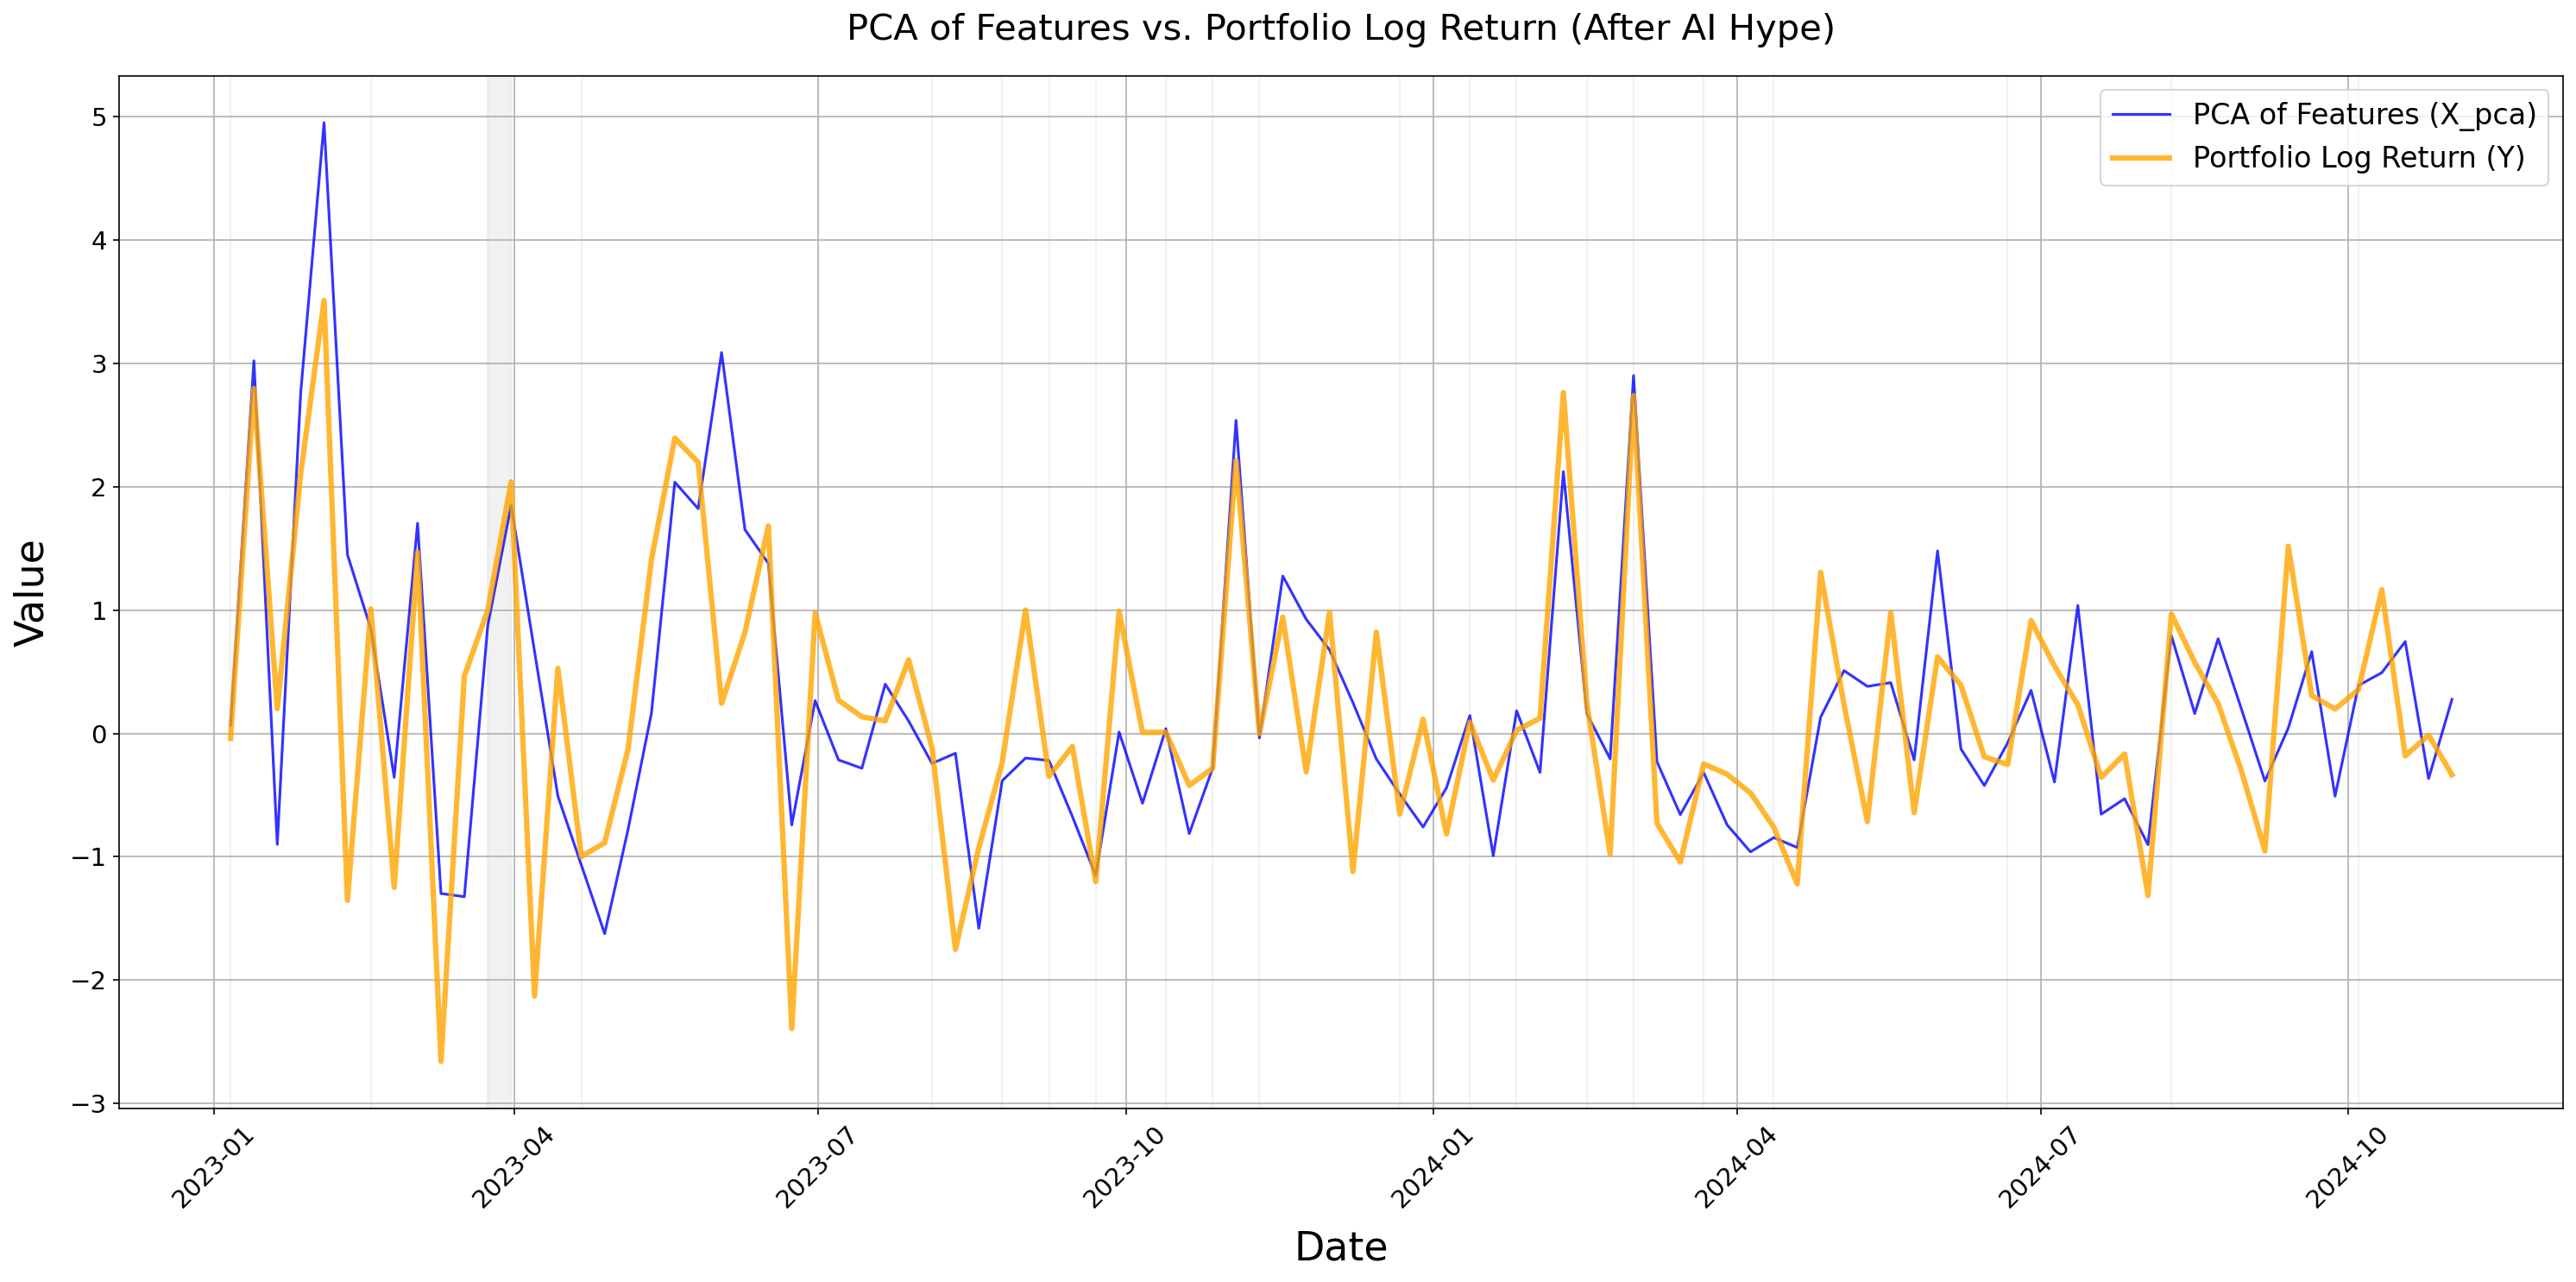

The number of times our PCA of Features got close Portfolio Log Return :21 


In [30]:
dates = portfolio['Date'].iloc[85:].reset_index(drop=True)
X_pca_slice = X_pca[85:].flatten()
Y_slice = Y[85:].values

threshold = 0.2
close_match = np.abs(X_pca_slice - Y_slice) < threshold
close_match_indices = np.where(close_match)[0]

intervals_post = []
if len(close_match_indices) > 0:
    start = close_match_indices[0]
    for i in range(1, len(close_match_indices)):
        if close_match_indices[i] != close_match_indices[i-1] + 1:
            intervals_post.append((start, close_match_indices[i-1]))
            start = close_match_indices[i]
    intervals_post.append((start, close_match_indices[-1]))

fig, ax = plt.subplots(figsize=(20, 10), dpi=150)
ax.plot(dates, X_pca_slice, label='PCA of Features (X_pca)',
        linewidth=1.5, alpha=0.8, color='blue')
ax.plot(dates, Y_slice, label='Portfolio Log Return (Y)', 
        linewidth=3, alpha=0.8, color='orange')

for (start_idx, end_idx) in intervals_post:
    ax.axvspan(dates[start_idx], dates[end_idx], color='lightgrey', alpha=0.3)

ax.set_title('PCA of Features vs. Portfolio Log Return (After AI Hype)', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=22, labelpad=10)
ax.set_ylabel('Value', fontsize=22, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"The number of times our PCA of Features got close Portfolio Log Return :{len(intervals_post)} ")

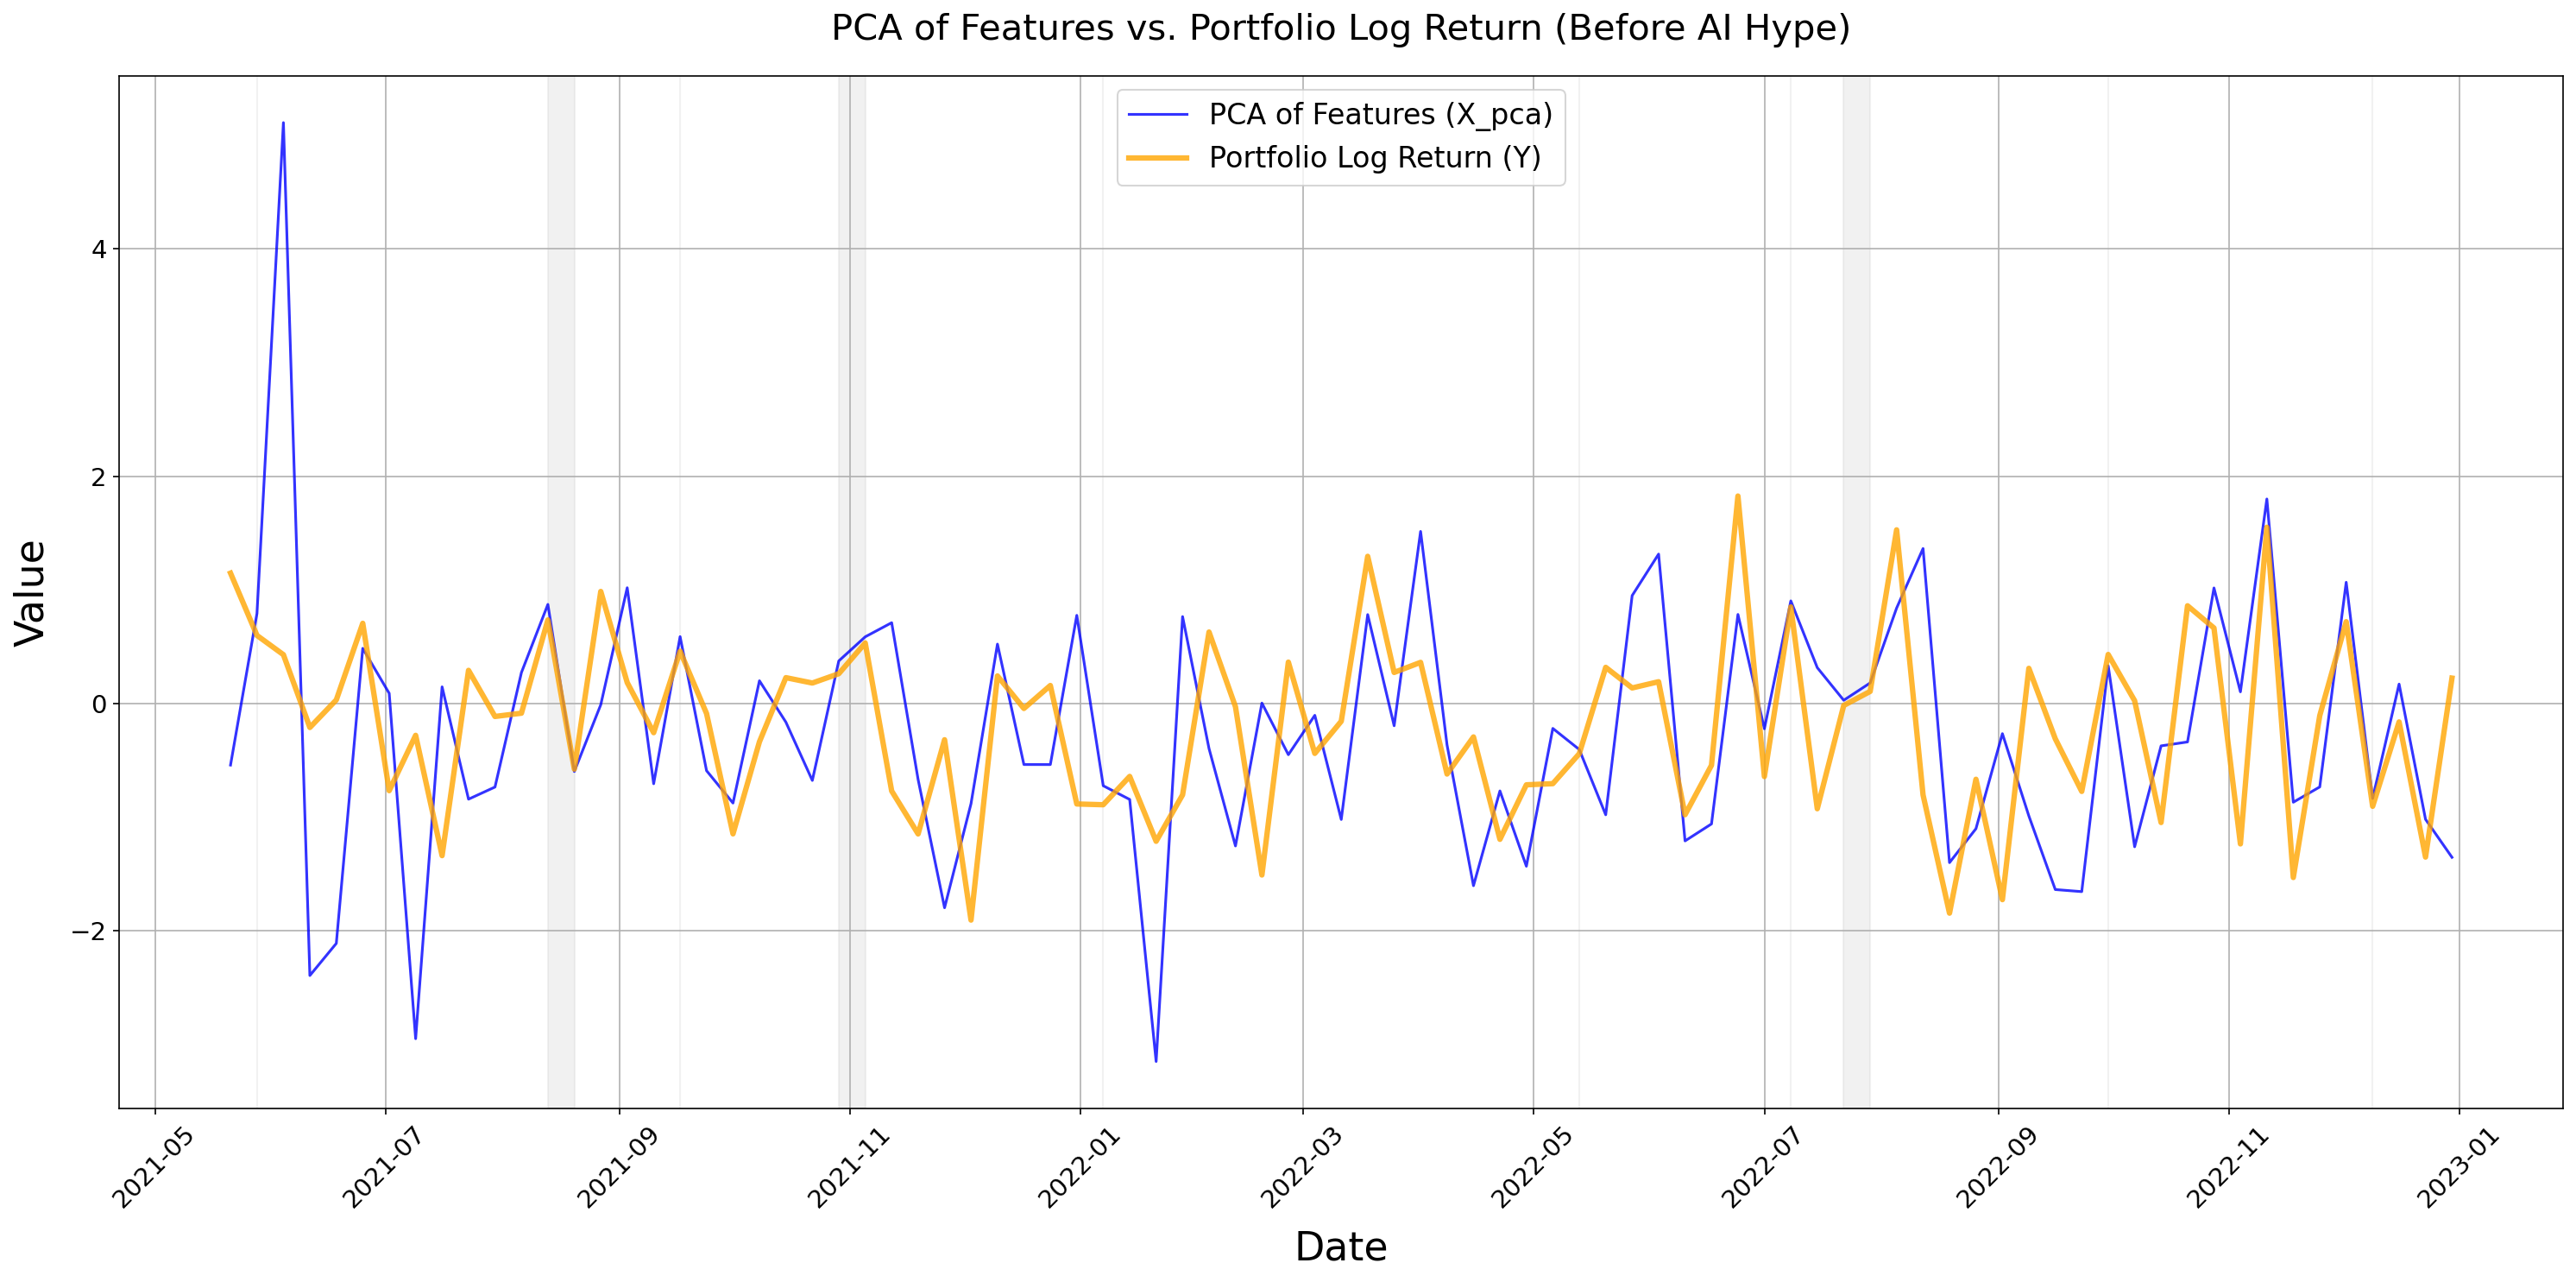

The number of times our PCA of Features got close Portfolio Log Return :10 


In [31]:
dates = portfolio['Date'].iloc[:85].reset_index(drop=True)
X_pca_slice = X_pca[:85].flatten()
Y_slice = Y[:85].values

threshold = 0.2
close_match = np.abs(X_pca_slice - Y_slice) < threshold
close_match_indices = np.where(close_match)[0]

intervals_pre = []
if len(close_match_indices) > 0:
    start = close_match_indices[0]
    for i in range(1, len(close_match_indices)):
        if close_match_indices[i] != close_match_indices[i-1] + 1:
            intervals_pre.append((start, close_match_indices[i-1]))
            start = close_match_indices[i]
    intervals_pre.append((start, close_match_indices[-1]))

fig, ax = plt.subplots(figsize=(20, 10), dpi=150)
ax.plot(dates, X_pca_slice, label='PCA of Features (X_pca)',
        linewidth=1.5, alpha=0.8, color='blue')
ax.plot(dates, Y_slice, label='Portfolio Log Return (Y)', 
        linewidth=3, alpha=0.8, color='orange')

for (start_idx, end_idx) in intervals_pre:
    ax.axvspan(dates[start_idx], dates[end_idx], color='lightgrey', alpha=0.3)

ax.set_title('PCA of Features vs. Portfolio Log Return (Before AI Hype)', fontsize=20, pad=20)

ax.set_xlabel('Date', fontsize=22, labelpad=10)
ax.set_ylabel('Value', fontsize=22, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print(f"The number of times our PCA of Features got close Portfolio Log Return :{len(intervals_pre)} ")

# Random Forest Classification and Hyperparameter Tuning
This code explores the application of Random Forest Classification for predicting categorical portfolio log returns. It performs hyperparameter tuning using RandomizedSearchCV and evaluates the model with cross-validation. Different parameters are tested, such as tree depth, number of estimators, and sample splits. For our research, no predictive power was gained, as it was not the intention; the goal was to explore and check for any interesting patterns.


In [32]:
portfolio = pd.DataFrame()
portfolio['Date'] = pltr['Date']  
portfolio['Portfolio Log Return'] = portfolio_log_return
portfolio['Date'] = pd.to_datetime(portfolio['Date'])

portfolio.loc[portfolio['Portfolio Log Return'] < 0, 'Portfolio Log Return'] = 'Up'
portfolio.loc[portfolio['Portfolio Log Return'] != 'Up', 'Portfolio Log Return'] = 'Down'
portfolio = portfolio[4:]

C:\Users\tural\AppData\Local\Temp\ipykernel_20420\809893286.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  portfolio['Date'] = pd.to_datetime(portfolio['Date'])


In [33]:
portfolio['Portfolio Log Return'].value_counts()

Portfolio Log Return
Up      102
Down     79
Name: count, dtype: int64

In [34]:
data['Log Returns'] = portfolio['Portfolio Log Return']

In [35]:
data['Log Returns'] = data['Log Returns'].shift(-1)
data['Portfolio Log Return'] = data['Portfolio Log Return'].shift(-1)

In [36]:
data.dropna(inplace=True)

In [37]:
X = data[['d_ST Lag 1', 'd_ST', 'Momentum 4W', 'd_VXN','d_CEFD', 'd_CEFD Lag 1']]

y_cat = data['Log Returns']
y_num = data['Portfolio Log Return']

Random Forest Classifier with Hyperparameter Tuning to predict log returns for next week

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
max_depth = [int(x) for x in np.linspace(3, 11, num = 6)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

In [39]:
random_grid

{'n_estimators': [50, 100, 150],
 'max_depth': [3, 4, 6, 7, 9, 11],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [40]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X, y_cat)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 6, 7, 9, 11],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 6}

In [43]:
scoring = ['precision_macro', 'recall_macro']

model_2 = RandomForestClassifier(n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_depth=4)

scores = cross_validate(model_2, X, y_cat, scoring=scoring, 
                       cv=10, return_train_score=True)
sorted(scores.keys())
scores['test_recall_macro'].mean()

0.5484090909090908

# QQplots

Text(0.5, 1.0, 'Q-Q Plot of Momentum')

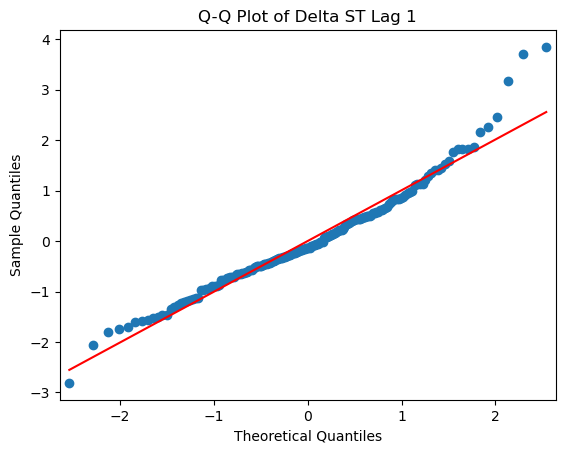

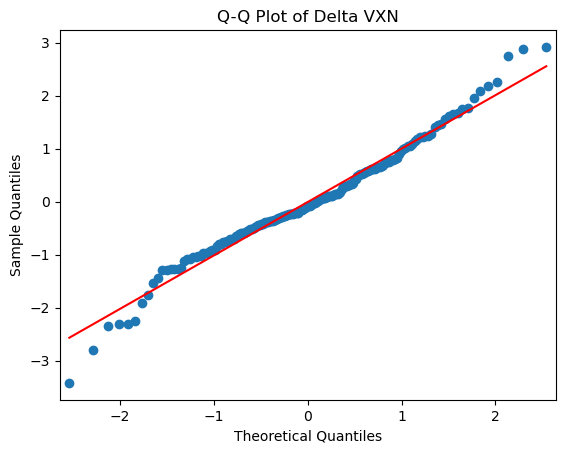

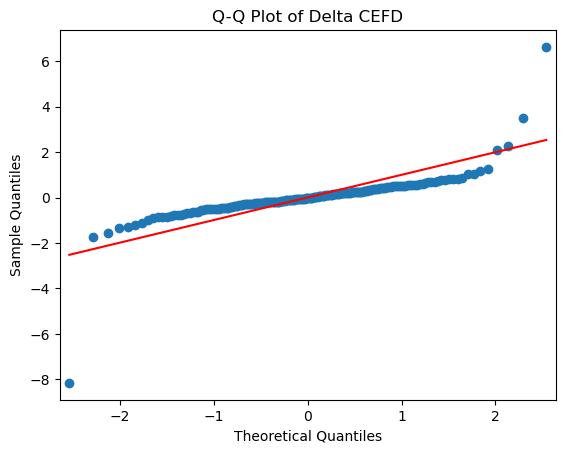

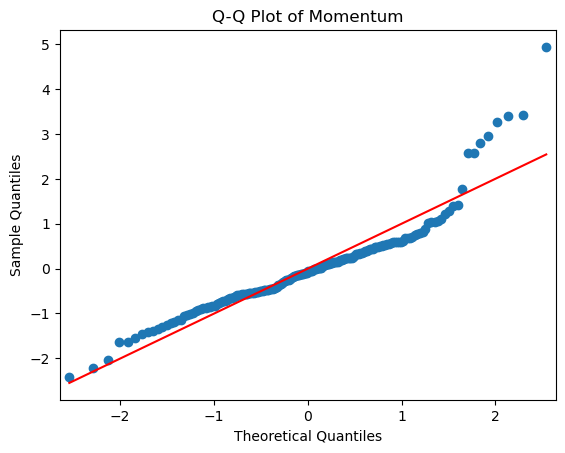

In [44]:
from scipy.stats import shapiro, normaltest, anderson

# Convert to a DataFrame for analysis
sm.qqplot(pd.Series(data['d_ST Lag 1']), line='s')
plt.title("Q-Q Plot of Delta ST Lag 1")

sm.qqplot(pd.Series(data['d_VXN']), line='s')
plt.title("Q-Q Plot of Delta VXN")

sm.qqplot(pd.Series(data['d_CEFD']), line='s')
plt.title("Q-Q Plot of Delta CEFD")

sm.qqplot(pd.Series(data['Momentum 4W']), line='s')
plt.title("Q-Q Plot of Momentum")
